# Compare Price and Speed

This notebook runs 200 epochs on a number of CPU and GPU instance types.  This information will then be used to select the best instance type for the [hyper-parameter tunning](tuning.ipynb).

#### Import necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import boto3
import math
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import seaborn as sns; sns.set()
from time import sleep

## Get the necessary account information

In [2]:
role = get_execution_role()
account = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name
image_names = {}
for t in ['cpu', 'gpu']:
    image_names[t] = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-tennis-{}:latest'.format(account, region, t)
    print(image_names[t])

031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-cpu:latest
031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-gpu:latest


#### Set for local parameters
Note prices are in $/hour and are from [here](https://aws.amazon.com/sagemaker/pricing/).

In [3]:
n_epochs = 1000
n_instances = 1

c = {'ml.m5.large': 0.134, 
     'ml.m5.xlarge': 0.269, 
     'ml.m5.2xlarge': 0.538,
     'ml.m4.xlarge': 0.28, 
     'ml.m4.2xlarge': 0.56,
     'ml.c5.xlarge': 0.238, 
     'ml.c5.2xlarge': 0.476,
     'ml.c5n.xlarge': 0.302, 
     'ml.c5n.2xlarge': 0.605,
     'ml.c4.xlarge': 0.279, 
     'ml.c4.2xlarge': 0.557}
c = pd.DataFrame(index=c.keys(), columns=['price'], data=c.values())
c['type'] = 'cpu'

g = {'ml.p2.xlarge': 1.26, 
     'ml.g4dn.xlarge': 0.736, 
     'ml.g4dn.2xlarge': 1.053}
g = pd.DataFrame(index=g.keys(), columns=['price'], data=g.values())
g['type'] = 'gpu'

results = pd.concat([c, g])
results['job_name'] = ''
results['time'] = np.nan
del c, g
results

,price,type,job_name,time
ml.m5.large,0.134,cpu,,NaN
ml.m5.xlarge,0.269,cpu,,NaN
ml.m5.2xlarge,0.538,cpu,,NaN
ml.m4.xlarge,0.280,cpu,,NaN
ml.m4.2xlarge,0.560,cpu,,NaN
ml.c5.xlarge,0.238,cpu,,NaN
ml.c5.2xlarge,0.476,cpu,,NaN
ml.c5n.xlarge,0.302,cpu,,NaN
ml.c5n.2xlarge,0.605,cpu,,NaN
ml.c4.xlarge,0.279,cpu,,NaN


### Please verify that the prices above haven't changed!!!
You may also want to add newly added instances.

## Run Sensitivity

#### Submit all the jobs

In [4]:
for i in results.index.tolist():
    estimator = Estimator(role=role,
                      train_instance_count=n_instances,
                      train_instance_type=i,
                      image_name=image_names[results.loc[i, 'type']],
                      hyperparameters={'epochs': n_epochs})
    estimator.fit(wait=False)
    results.loc[i, 'job_name'] = estimator._current_job_name

#### Wait for the jobs to complete and compile billable times
Note times are in seconds but prices in $/hour.

In [5]:
client = boto3.client('sagemaker')
for i in results.index.tolist():
    while True:
        info = client.describe_training_job(TrainingJobName=results.loc[i, 'job_name'])
        if info['TrainingJobStatus'] == 'Completed':
            results.loc[i, 'time'] = info['BillableTimeInSeconds']
            print('{} complete.'.format(i))
            break
        elif info['TrainingJobStatus'] == 'Failed':
            print('ERROR:  {}, {} failed!!!'.format(i, results.loc[i, 'job_name']))
            break
        else:
            sleep(60)    

ml.m5.large complete.
ml.m5.xlarge complete.
ml.m5.2xlarge complete.
ml.m4.xlarge complete.
ml.m4.2xlarge complete.
ml.c5.xlarge complete.
ml.c5.2xlarge complete.
ml.c5n.xlarge complete.
ml.c5n.2xlarge complete.
ml.c4.xlarge complete.
ml.c4.2xlarge complete.
ml.p2.xlarge complete.
ml.g4dn.xlarge complete.
ml.g4dn.2xlarge complete.


#### Compile the job info
Note the cost is in cents, time in seconds and price in \\$ per hour.  
3600 converts seconds to hours and 100 converts \\$ to cents.


In [6]:
results['cost'] = results['price'] * results['time'] / 3600 * 100
results['eff'] = results['cost'] * results['time']
results.to_csv('results.csv')
results


,price,type,job_name,time,cost,eff
ml.m5.large,0.134,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-40-971,865.0,3.219722,2785.059722
ml.m5.xlarge,0.269,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-41-514,1169.0,8.735028,10211.247472
ml.m5.2xlarge,0.538,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-42-002,1063.0,15.885944,16886.758944
ml.m4.xlarge,0.280,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-45-382,1470.0,11.433333,16807.000000
ml.m4.2xlarge,0.560,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-47-773,996.0,15.493333,15431.360000
ml.c5.xlarge,0.238,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-48-369,990.0,6.545000,6479.550000
ml.c5.2xlarge,0.476,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-50-878,972.0,12.852000,12492.144000
ml.c5n.xlarge,0.302,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-51-760,1056.0,8.858667,9354.752000
ml.c5n.2xlarge,0.605,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-57-942,900.0,15.125000,13612.500000
ml.c4.xlarge,0.279,cpu,sagemaker-tennis-cpu-2020-07-04-16-59-58-288,1284.0,9.951000,12777.084000


#### Make a pretty plot 

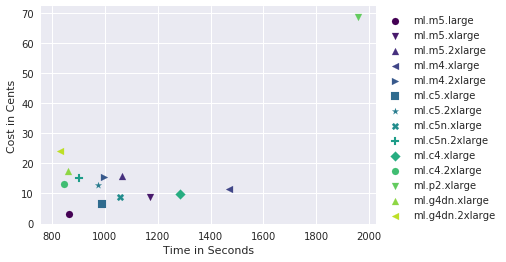

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as colors

colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, results.shape[0])]

markers = ['o', 'v', '^', '<', '>', 's', 
           '*', 'X', 'P', 'D'] * math.ceil(results.shape[0]/10)

fig, ax = plt.subplots()
for i, name in enumerate(results.index.tolist()):
    ax.scatter(results.loc[name, 'time'], results.loc[name, 'cost'], label=name, s=50, 
               linewidth=0.1, c=colorlist[i], marker=markers[i])
ax.legend(bbox_to_anchor=(1,1))

# ax = results.plot.scatter(x='time', y='cost', c='blue')
_ = ax.set(xlabel="Time in Seconds", ylabel="Cost in Cents")
plt.show()

# Conclusion

In [8]:
for n, t in zip([results.price.idxmin(), results.time.idxmin(), results.eff.idxmin()],
                ['cheapest', 'fastest', 'most efficient']):
    print("{} is the {} instance type; {:.1f} min and ${:.3f}.".format(n, t, 
                                                                    results.loc[n, 'time']/60,
                                                                    results.loc[n, 'cost']/100))


ml.m5.large is the cheapest instance type; 14.4 min and $0.032.
ml.g4dn.2xlarge is the fastest instance type; 13.8 min and $0.242.
ml.m5.large is the most efficient instance type; 14.4 min and $0.032.


# Reference
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)
- [SageMaker Estimator SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)